# Imports 

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy as sp
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load Data

In [20]:
final_ds = pd.read_csv('/content/drive/My Drive/final_ds.csv')
final_ds.drop('Unnamed: 0', axis=1, inplace=True)
final_ds

latitude  level  longitude  ...          cswc          t  snow_frac
0             40.0      1    -123.75  ... -1.164153e-10 -16.945013        1.0
1             40.0      2    -123.75  ... -1.164153e-10 -17.418356        1.0
2             40.0      3    -123.75  ... -1.164153e-10 -26.769553        1.0
3             40.0      5    -123.75  ... -1.164153e-10 -35.251242        1.0
4             40.0      7    -123.75  ... -1.164153e-10 -47.076849        1.0
...            ...    ...        ...  ...           ...        ...        ...
10897198      83.0    900     -66.50  ... -1.164153e-10   4.172876        0.0
10897199      83.0    925     -66.50  ... -1.164153e-10   5.168329        0.0
10897200      83.0    950     -66.50  ... -1.164153e-10   4.875787        1.0
10897201      83.0    975     -66.50  ... -1.164153e-10   3.821436        0.0
10897202      83.0   1000     -66.50  ... -1.164153e-10   2.393243        0.0

[10897203 rows x 10 columns]

In [21]:
# Fix invalid snow fraction values
final_ds['snow_frac'] = final_ds['snow_frac'].map(lambda x: 0 if x < 0 else x) 
final_ds['snow_frac'] = final_ds['snow_frac'].map(lambda x: 1 if x > 1 else x) 

In [8]:
final_ds.set_index(['latitude', 'longitude', 'time'])

level            z  ...          t  snow_frac
latitude longitude time                            ...                      
40.0     -123.75   2019-02-15      1  460384.1600  ... -16.945013        1.0
                   2019-02-15      2  409153.7000  ... -17.418356        1.0
                   2019-02-15      3  379902.9700  ... -26.769553        1.0
                   2019-02-15      5  344388.5300  ... -35.251242        1.0
                   2019-02-15      7  321916.5000  ... -47.076849        1.0
...                              ...          ...  ...        ...        ...
83.0     -66.50    2019-08-15    900    9853.0310  ...   4.172876        0.0
                   2019-08-15    925    7664.1562  ...   5.168329        0.0
                   2019-08-15    950    5528.2812  ...   4.875787        1.0
                   2019-08-15    975    3453.0156  ...   3.821436        0.0
                   2019-08-15   1000    1445.9062  ...   2.393243        0.0

[10897203 rows x 7 columns]

In [9]:
# Check that every level has the same number of samples+
final_ds['level'].value_counts()

1000    294519
300     294519
225     294519
200     294519
175     294519
150     294519
125     294519
100     294519
70      294519
50      294519
30      294519
20      294519
10      294519
7       294519
5       294519
3       294519
2       294519
250     294519
350     294519
975     294519
400     294519
950     294519
925     294519
900     294519
875     294519
850     294519
825     294519
800     294519
775     294519
750     294519
700     294519
650     294519
600     294519
550     294519
500     294519
450     294519
1       294519
Name: level, dtype: int64

In [22]:
final_ds

latitude  level  longitude  ...          cswc          t  snow_frac
0             40.0      1    -123.75  ... -1.164153e-10 -16.945013        1.0
1             40.0      2    -123.75  ... -1.164153e-10 -17.418356        1.0
2             40.0      3    -123.75  ... -1.164153e-10 -26.769553        1.0
3             40.0      5    -123.75  ... -1.164153e-10 -35.251242        1.0
4             40.0      7    -123.75  ... -1.164153e-10 -47.076849        1.0
...            ...    ...        ...  ...           ...        ...        ...
10897198      83.0    900     -66.50  ... -1.164153e-10   4.172876        0.0
10897199      83.0    925     -66.50  ... -1.164153e-10   5.168329        0.0
10897200      83.0    950     -66.50  ... -1.164153e-10   4.875787        1.0
10897201      83.0    975     -66.50  ... -1.164153e-10   3.821436        0.0
10897202      83.0   1000     -66.50  ... -1.164153e-10   2.393243        0.0

[10897203 rows x 10 columns]

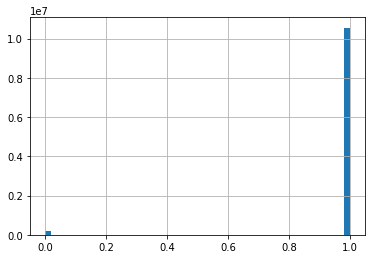

In [10]:
final_ds['snow_frac'].hist(bins=50)

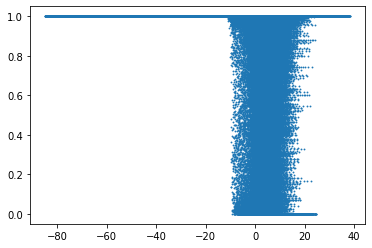

In [11]:
plt.scatter(final_ds.t, final_ds.snow_frac, s=0.7)

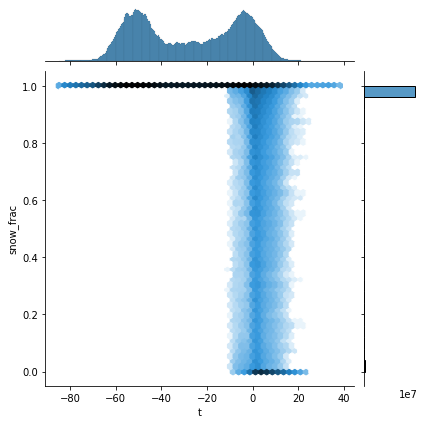

In [12]:
sns.jointplot(x=final_ds['t'], y=final_ds['snow_frac'], kind='hex', bins='log') 

In [ ]:
# final_ds.to_csv('/content/drive/My Drive/final_ds.csv')

# Isotonic Regression

In [ ]:
from sklearn.isotonic import IsotonicRegression

x = final_ds['t']
y = final_ds['snow_frac']
xx = np.linspace(x.min(), x.max(), 1000) # for graphing

ir = IsotonicRegression(increasing=False).fit(x, y)

# Actual predictions
y_pred = ir.predict(x)

# For graphing
yy_pred = ir.predict(xx)

In [ ]:
plt.scatter(x, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
plt.plot(xx, yy_pred, color='green', label= 'Isotonic', linewidth=2)
plt.xlabel('Air Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')

Text(0, 0.5, 'Snow Fraction')

# Pivoting


In [38]:
ds = final_ds[['latitude', 'level', 'longitude', 'time', 't', 'snow_frac']]
final_ds_pivoted = ds.pivot(index=['latitude', 'longitude', 'time'], columns='level').reset_index()
final_ds_pivoted.columns = ["_".join((str(j), str(i))) for i,j in final_ds_pivoted.columns]
final_ds_pivoted.rename(columns={'_latitude': 'latitude', '_longitude': 'longitude', '_time': 'time'}, inplace=True)
final_ds_pivoted.set_index(['latitude', 'longitude', 'time'], inplace=True)
final_ds_pivoted

1_t  ...  1000_snow_frac
latitude longitude time                   ...                
40.0     -123.75   2019-02-15 -16.945013  ...             0.0
                   2019-12-15 -10.139349  ...             0.0
         -123.50   2019-02-15 -17.022192  ...             0.0
                   2019-12-15 -10.025580  ...             0.0
         -123.25   2018-03-15 -10.893042  ...             0.0
...                                  ...  ...             ...
83.0     -66.50    2018-06-15   9.353326  ...             1.0
                   2018-07-15   9.790094  ...             1.0
                   2018-08-15   3.463861  ...             0.0
                   2019-06-15   9.989191  ...             0.0
                   2019-08-15   4.601526  ...             0.0

[294519 rows x 74 columns]

In [39]:
final_ds_pivoted.sort_index(level=1)

1_t  ...  1000_snow_frac
latitude longitude time                   ...                
52.75    -170.0    2018-01-15 -31.838248  ...        0.000000
                   2018-02-15 -21.079199  ...        0.000000
                   2018-03-15  -7.469885  ...        0.000000
                   2018-05-15  -5.684180  ...        1.000000
                   2018-11-15 -35.328436  ...        0.000000
...                                  ...  ...             ...
82.25    -50.0     2019-08-15   3.882379  ...        1.000000
82.50    -50.0     2018-06-15   8.045007  ...        1.000000
                   2018-07-15   8.745874  ...        1.000000
                   2018-08-15   2.053979  ...        0.030749
                   2019-08-15   3.904718  ...        0.000000

[294519 rows x 74 columns]

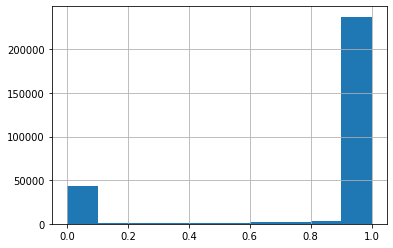

In [40]:
final_ds_pivoted['1000_snow_frac'].hist()

In [ ]:
# final_ds_pivoted.to_csv('/content/drive/My Drive/df_pivoted.csv')

# Classification Functions

In [41]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

def cm_plot(y_true, y_pred, classes, cm_fig_path=None,
                normalize=False,
                title=None,
                cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    samples = np.array(y_true).shape[0]
    accuracy = np.trace(cm) / float(np.sum(cm)) * 100
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # print('for i {} and j {} : {}'.format(i, j, cm[i,j]))
            ax.annotate(format(cm[i, j], fmt), (j, i),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")
    np.set_printoptions(precision=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('\nPredicted label\naccuracy={:0.2f}%; N={}'.format(accuracy, samples))
    plt.ylim([2.5, -.5])
    plt.tight_layout()
    if cm_fig_path is not None:
        plt.savefig(cm_fig_path)
    plt.show()
    plt.close('all')


In [42]:
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, PowerTransformer

def Standardize(X, y, method="robust"):
    if method == "robust":
        X_norm = RobustScaler().fit_transform(np.array(X))
    elif method == "standard":
        X_norm = StandardScaler().fit_transform(np.array(X))
    elif method == "power":
        X_norm = PowerTransformer().fit_transform(np.array(X))
    elif method == "none":
        X_norm = X
    y_encoded = LabelEncoder().fit_transform(y)
    return X_norm, y_encoded

In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

def Train_and_Evaluate_Classifier(X, y_encoded, y, classifier='sgd', normalize=None, kernel='linear', ccp_alpha=0.015, max_depth=30, min_samples_leaf=0.05, min_samples_split=0.05, max_iter=1000):
    if classifier == 'sgd':
        clf = SGDClassifier(class_weight="balanced", penalty='l1')
        title = "SGD Classifier"
    elif classifier == 'svm':
        if kernel == 'linear':
            clf = LinearSVC(dual=False, class_weight='balanced', penalty='l1', max_iter=max_iter)
            title = "LinearSVM Classifier"
        else:
            clf = SVC(kernel=kernel, class_weight='balanced', cache_size=4*1024)
            title = str(kernel + " SVM Classifier")
    elif classifier == 'nb':
        clf = GaussianNB()
#         clf.partial_fit(X, y_encoded, classes=np.unique(y_encoded))
        title = "Naive Bayes Classifier"
    elif classifier == 'gp':
        clf = GaussianProcessClassifier(copy_X_train=False)
        title = 'Gaussian Process Classifier'
    elif classifier == "decision_tree":
        clf = DecisionTreeClassifier(
            class_weight='balanced', 
            ccp_alpha=ccp_alpha, 
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth, 
            min_samples_split=min_samples_split
        )
        title = "Decision Tree Classifier"
    elif classifier == "random_forest":
        clf = RandomForestClassifier(
            n_jobs=-1, 
            class_weight="balanced_subsample",
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=ccp_alpha
        )
        title = "Random Forest Classifier"
    clf.fit(X, y_encoded)
    y_pred = clf.predict(X)           
    pred = [round(value) for value in y_pred]
    print("Classifier Accuracy %.2f%%" % (balanced_accuracy_score(y_encoded, pred) * 100.0))
    print('------------------------------------------------------------------------')
    print(classification_report(y_encoded, pred, target_names=list(np.unique(y))))
    cm_plot(y_encoded, y_pred, list(np.unique(y)), normalize=normalize, cm_fig_path='cm.png', title=title)
    return clf, y_pred

In [44]:
def Precip_Type(x, lower_thresh=0.05, upper_thresh=0.95):
    if x <= lower_thresh:
        return "Rain"
    elif x > lower_thresh and x <= upper_thresh:
        return "Mixed"
    else:
        return "Snow"
        

# Classification

In [45]:
final_ds_pivoted['precip_type'] = final_ds_pivoted['1000_snow_frac'].map(Precip_Type)
final_ds_pivoted

1_t        2_t  ...  1000_snow_frac  precip_type
latitude longitude time                              ...                             
40.0     -123.75   2019-02-15 -16.945013 -17.418356  ...             0.0         Rain
                   2019-12-15 -10.139349 -29.861563  ...             0.0         Rain
         -123.50   2019-02-15 -17.022192 -17.383826  ...             0.0         Rain
                   2019-12-15 -10.025580 -29.873755  ...             0.0         Rain
         -123.25   2018-03-15 -10.893042 -21.617560  ...             0.0         Rain
...                                  ...        ...  ...             ...          ...
83.0     -66.50    2018-06-15   9.353326   5.806238  ...             1.0         Snow
                   2018-07-15   9.790094  10.360956  ...             1.0         Snow
                   2018-08-15   3.463861  -2.600287  ...             0.0         Rain
                   2019-06-15   9.989191   5.103326  ...             0.0         Rain
                   2019-08-15   4.601526  -3.853735  ...             0.0         Rain

[294519 rows x 75 columns]

In [46]:
final_ds_pivoted['precip_type'].value_counts()

Snow     234230
Rain      43107
Mixed     17182
Name: precip_type, dtype: int64

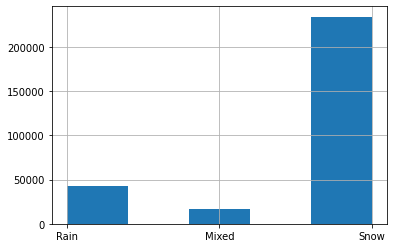

In [47]:
final_ds_pivoted['precip_type'].hist(bins=5)

Class imbalance needs to be addressed

In [48]:
y = final_ds_pivoted['precip_type']
X = final_ds_pivoted.drop(['1000_snow_frac', 'precip_type'], axis=1)

In [65]:
def correlation_plot(data, title=None, save_name=None, annot=True, num_fts=50):
    '''
    Plot correlations between different feature pairs for real and fake data.
    Input:
        data -- Input data (pandas DataFrame)
        annot -- Annotate graph with correlation values (bool)
    Output:
        corr_real -- Correlation values for feature pairs for input data (pandas DataFrame)
        '''
    corr_real = data.corr()
    fig, ax = plt.subplots(figsize=(num_fts, num_fts)) 
    mask = np.zeros_like(corr_real)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        if title is not None:
            ax.set_title(title)
        else:
            ax.set_title("Feature Correlation Matrix")
        ax = sns.heatmap(
            corr_real, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            annot=annot,
            mask=mask,
            cbar=False,
            ax=ax
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )
        
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    if save_name is not None:
        plt.savefig(save_name)
    else:
        plt.savefig('Corr_matrix.png')   
        
    plt.show()
    plt.clf()
    return corr_real

In [ ]:
correlation_plot(
    X,
    title="Feature Correlations",
    num_fts=X.shape[1]
)

In [49]:
encodings = {"Rain": 1, "Mixed": 0, "Snow": 2}

In [ ]:
rain_df = final_ds_pivoted[final_ds_pivoted['precip_type'] == 'Rain'].reset_index()
snow_df = final_ds_pivoted[final_ds_pivoted['precip_type'] == 'Snow'].reset_index()
mixed_df = final_ds_pivoted[final_ds_pivoted['precip_type'] == 'Mixed'].reset_index()

In [50]:
X_norm_pow, y_encoded = Standardize(X, y, method='power')
X_norm_robust, y_encoded = Standardize(X, y, method='robust')
X_norm_std, y_encoded = Standardize(X, y, method='standard')
X_norm, y_encoded = Standardize(X, y, method='none')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


#### SVM

In [57]:
linsvm, linsvm_pred = Train_and_Evaluate_Classifier(X_norm_robust, y_encoded, y, classifier='svm', normalize='all', kernel='linear', max_iter=10000) 

Classifier Accuracy 71.03%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.82      0.20      0.32     17182
        Rain       0.88      0.94      0.91     43107
        Snow       0.96      1.00      0.98    234230

    accuracy                           0.94    294519
   macro avg       0.88      0.71      0.73    294519
weighted avg       0.94      0.94      0.93    294519



#### SGD

In [60]:
Train_and_Evaluate_Classifier(X_norm_pow, y_encoded, y, normalize='all') 

Classifier Accuracy 72.25%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.55      0.30      0.39     17182
        Rain       0.81      0.87      0.84     43107
        Snow       0.98      1.00      0.99    234230

    accuracy                           0.94    294519
   macro avg       0.78      0.72      0.74    294519
weighted avg       0.93      0.94      0.93    294519



(SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 array([0, 1, 0, ..., 1, 1, 1]))

#### Random Forests

Classifier Accuracy 92.53%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.50      0.94      0.65     17182
        Rain       0.96      0.90      0.93     43107
        Snow       0.99      0.94      0.96    234230

    accuracy                           0.93    294519
   macro avg       0.82      0.93      0.85    294519
weighted avg       0.96      0.93      0.94    294519



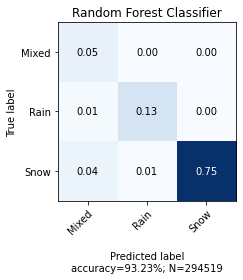

In [69]:
 rf, rf_pred = Train_and_Evaluate_Classifier(
    X_norm_robust, 
    y_encoded, 
    y, 
    classifier='random_forest', 
    normalize='all',
    ccp_alpha=1e-5,
    min_samples_leaf=1,
    max_depth=None
)

In [82]:
from rfpimp import permutation_importances

def balanced_accuracy(rf, X_train, y_train):
    return balanced_accuracy_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(
    rf, 
    pd.DataFrame(X_norm_robust, columns=X.columns.to_list()), 
    pd.Series(y_encoded), 
    balanced_accuracy
    )

In [83]:
perm_imp_rfpimp

Importance
Feature                  
975_snow_frac    0.156157
975_t            0.012053
950_snow_frac    0.010507
1000_t           0.002954
950_t            0.002555
...                   ...
825_t           -0.001286
2_t             -0.001375
125_t           -0.001872
175_t           -0.002296
200_t           -0.002798

[73 rows x 1 columns]

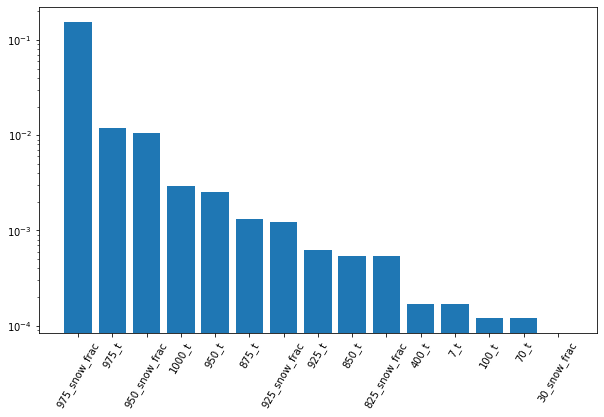

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(perm_imp_rfpimp.index[:15], perm_imp_rfpimp['Importance'][:15])
plt.xticks(rotation=60)
plt.yscale('log')